In [5]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Set working directory
os.chdir("/Users/nahian/Documents/RNA_Seq/Trim28_65/outs/filtered_feature_bc_matrix")

# Load data
adata = sc.read_10x_mtx(".", var_names='gene_symbols', cache=True)
adata.var_names_make_unique()

# Load metrics for reference (adjust path to parent directory)
metrics_path = "/Users/nahian/Documents/RNA_Seq/Trim28_65/outs/metrics_summary.csv"
metrics = pd.read_csv(metrics_path)
print(metrics.head())

  Estimated Number of Cells Mean Reads per Cell Median Genes per Cell  \
0                     2,448             134,069                 3,804   

  Number of Reads Valid Barcodes Valid UMIs Sequencing Saturation  \
0     328,200,630          98.5%     100.0%                 70.1%   

  Q30 Bases in Barcode Q30 Bases in RNA Read Q30 Bases in UMI  \
0                98.9%                 77.1%            98.7%   

  Reads Mapped to Genome Reads Mapped Confidently to Genome  \
0                  89.9%                              85.1%   

  Reads Mapped Confidently to Intergenic Regions  \
0                                           2.3%   

  Reads Mapped Confidently to Intronic Regions  \
0                                         5.7%   

  Reads Mapped Confidently to Exonic Regions  \
0                                      77.1%   

  Reads Mapped Confidently to Transcriptome Reads Mapped Antisense to Gene  \
0                                     77.9%                           4.5% 

# Quality Control

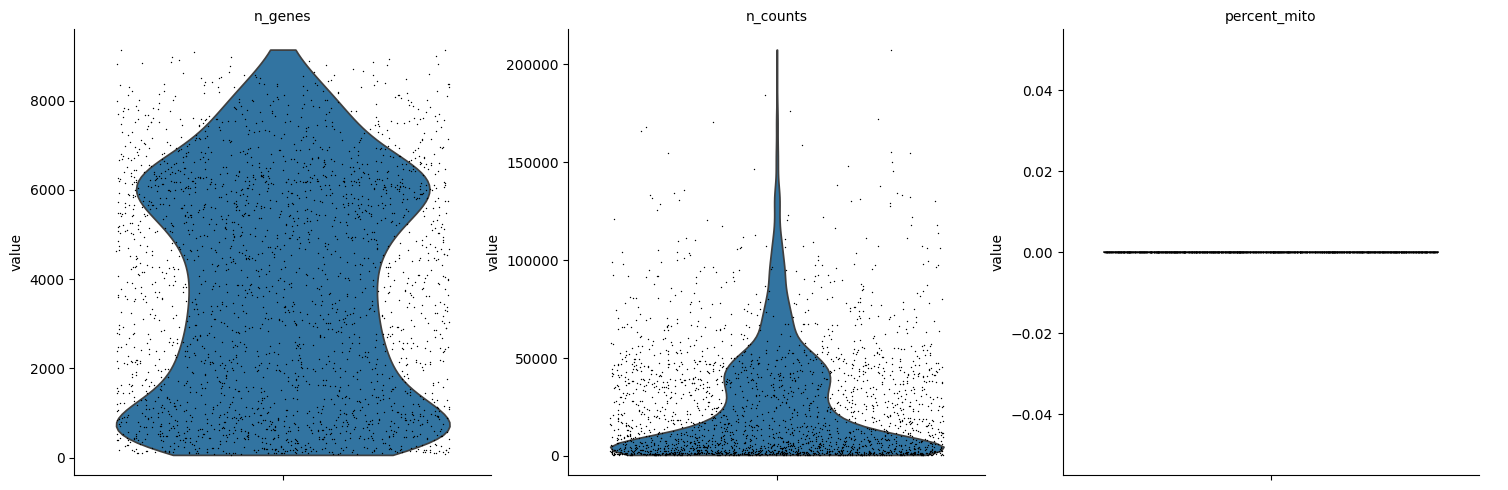

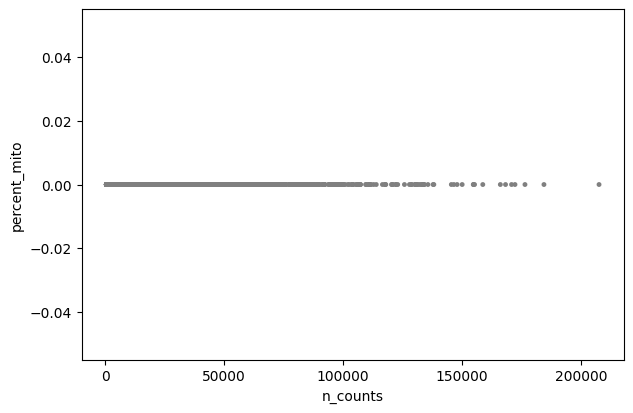

Cells after filtering: 1566


/Users/nahian/Documents/RNA_Seq/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


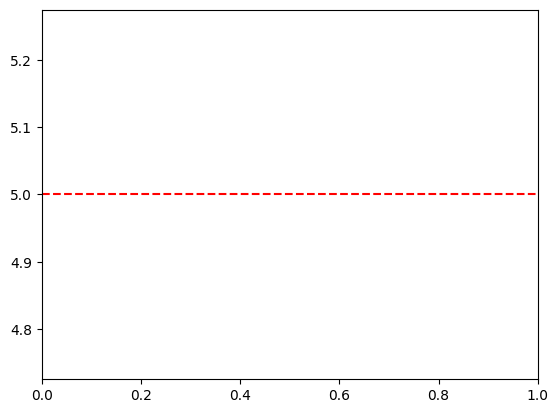

In [7]:
# Add QC metrics
adata.obs['n_counts'] = adata.X.sum(axis=1).A1  # Convert sparse to array
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Mouse mitochondrial genes
adata.obs['percent_mito'] = np.sum(adata[:, adata.var['mt']].X, axis=1).A1 / adata.obs['n_counts'] * 100

# Visualize QC
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color='gray')
plt.axhline(y=5, color='r', linestyle='--')  # Threshold based on typical scRNA-seq

# Filter cells (adjusted based on median genes ~3,804)
adata = adata[adata.obs['n_genes'] > 500, :]  # Lower bound to retain cells
adata = adata[adata.obs['n_genes'] < 6000, :]  # Upper bound from metrics
adata = adata[adata.obs['percent_mito'] < 10, :]  # Adjusted for potential variation
sc.pp.filter_genes(adata, min_cells=3)
print(f"Cells after filtering: {adata.n_obs}")


# Normalization and Highly Variable Genes (HVGs)

In [8]:
# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]
print(f"Highly variable genes: {adata.n_vars}")

Highly variable genes: 3973


In [9]:
# Scale and regress out unwanted variation
sc.pp.scale(adata, max_value=10)
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

# PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
n_pcs = 20  # Default based on dataset size; adjust if elbow suggests otherwise

# Compute neighborhood graph
sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=10)

/Users/nahian/Documents/RNA_Seq/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


ImportError: cannot import name '_lazywhere' from 'scipy._lib._util' (/Users/nahian/Documents/RNA_Seq/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py)

In [11]:
# Check what columns you have in adata.obs
print("Available columns in adata.obs:")
print(adata.obs.columns.tolist())

Available columns in adata.obs:
['n_counts', 'n_genes', 'percent_mito']


In [10]:
import statsmodels
print(statsmodels.__version__)

0.14.2


In [12]:
try:
    import statsmodels.api as sm
    print("statsmodels imported successfully")
except ImportError as e:
    print(f"statsmodels import failed: {e}")

statsmodels import failed: cannot import name '_lazywhere' from 'scipy._lib._util' (/Users/nahian/Documents/RNA_Seq/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py)


statsmodels version: 0.14.2
Regression failed: cannot import name '_lazywhere' from 'scipy._lib._util' (/Users/nahian/Documents/RNA_Seq/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py). Skipping regression and proceeding.


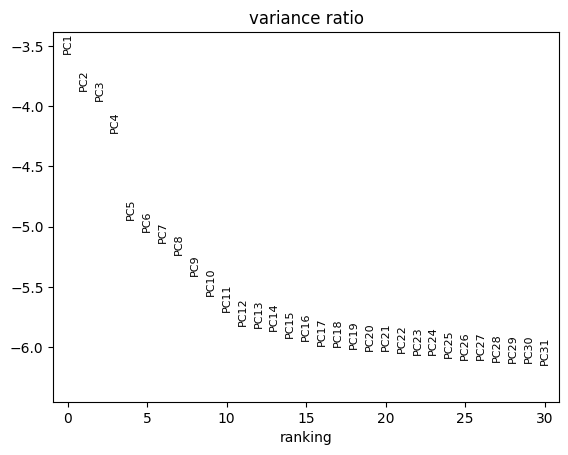

/Users/nahian/Documents/RNA_Seq/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/7n/wvyv6kmj0n3875y743qqmzzr0000gn/T/ipykernel_13213/3384976734.py:27: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


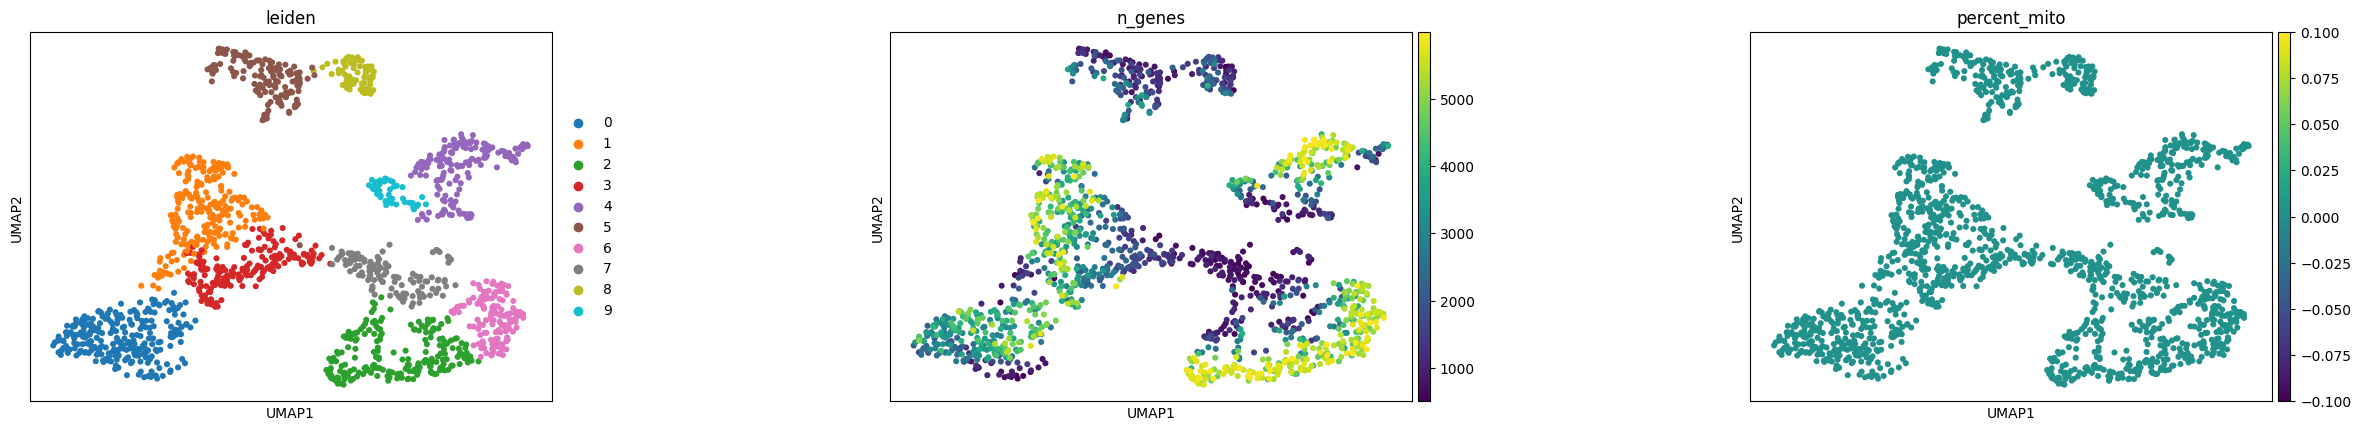

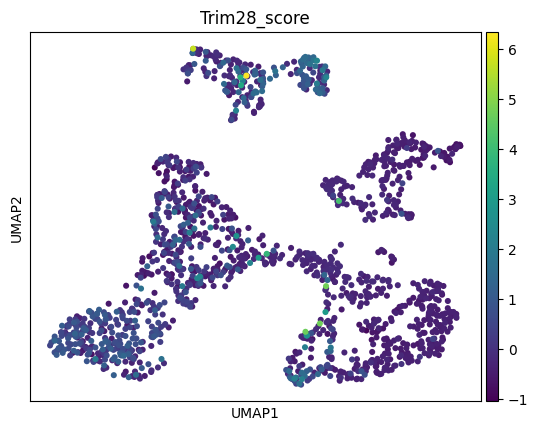

Analysis complete. Files saved.


<Figure size 640x480 with 0 Axes>

In [13]:
import statsmodels
print("statsmodels version:", statsmodels.__version__)

import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Try regression with error handling
try:
    sc.pp.scale(adata, max_value=10)
    sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
except ImportError as e:
    print(f"Regression failed: {e}. Skipping regression and proceeding.")
    sc.pp.scale(adata, max_value=10)  # Proceed without regression

# PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
n_pcs = 20  # Adjust if elbow plot suggests otherwise

# Compute neighborhood graph
sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=10)

# Clustering and UMAP
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden', 'n_genes', 'percent_mito'], wspace=0.5)

# Trim28 Annotation
trim28_markers = ['Trim28', 'Cdx2', 'Sox17']
sc.tl.score_genes(adata, gene_list=trim28_markers, score_name='Trim28_score')
sc.pl.umap(adata, color='Trim28_score', cmap='viridis')

# Save Results
output_dir = "/Users/nahian/Documents/RNA_Seq/Trim28_65/outs"
adata.write(os.path.join(output_dir, "Trim28_65_analysis.h5ad"))
plt.savefig(os.path.join(output_dir, "umap_trim28_plot.png"), dpi=300)
print("Analysis complete. Files saved.")

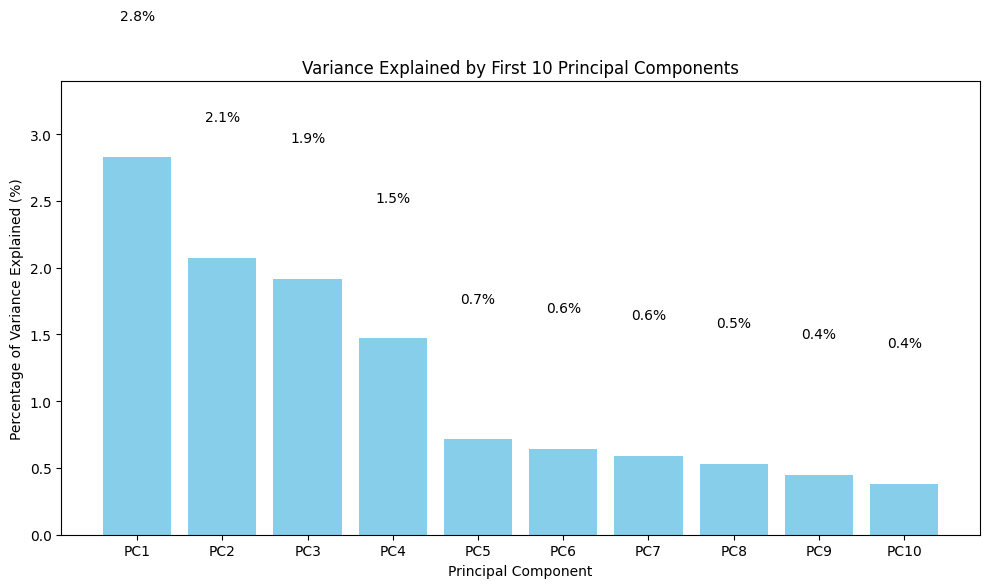

Bar chart saved as pca_variance_barplot_percentage.png. Awaiting further directions.


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os

# Assuming adata is already loaded and preprocessed (QC, normalization, scaling)
# If not, ensure previous steps are run; otherwise, reload and preprocess
output_dir = "/Users/nahian/Documents/RNA_Seq/Trim28_65/outs"

# Recompute PCA
sc.tl.pca(adata, svd_solver='arpack')

# Extract variance ratios for the first 10 PCs and convert to percentages
variance_ratio = adata.uns['pca']['variance_ratio'][:10] * 100  # Convert to percentage
pc_names = [f'PC{i+1}' for i in range(10)]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(pc_names, variance_ratio, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained (%)')
plt.title('Variance Explained by First 10 Principal Components')
plt.ylim(0, max(variance_ratio) * 1.2)  # Add some headroom
for bar, v in zip(bars, variance_ratio):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{v:.1f}%', ha='center', va='bottom')  # Add percentage labels
plt.tight_layout()

# Save the bar chart
plt.savefig(os.path.join(output_dir, "pca_variance_barplot_percentage.png"), dpi=300)
plt.show()


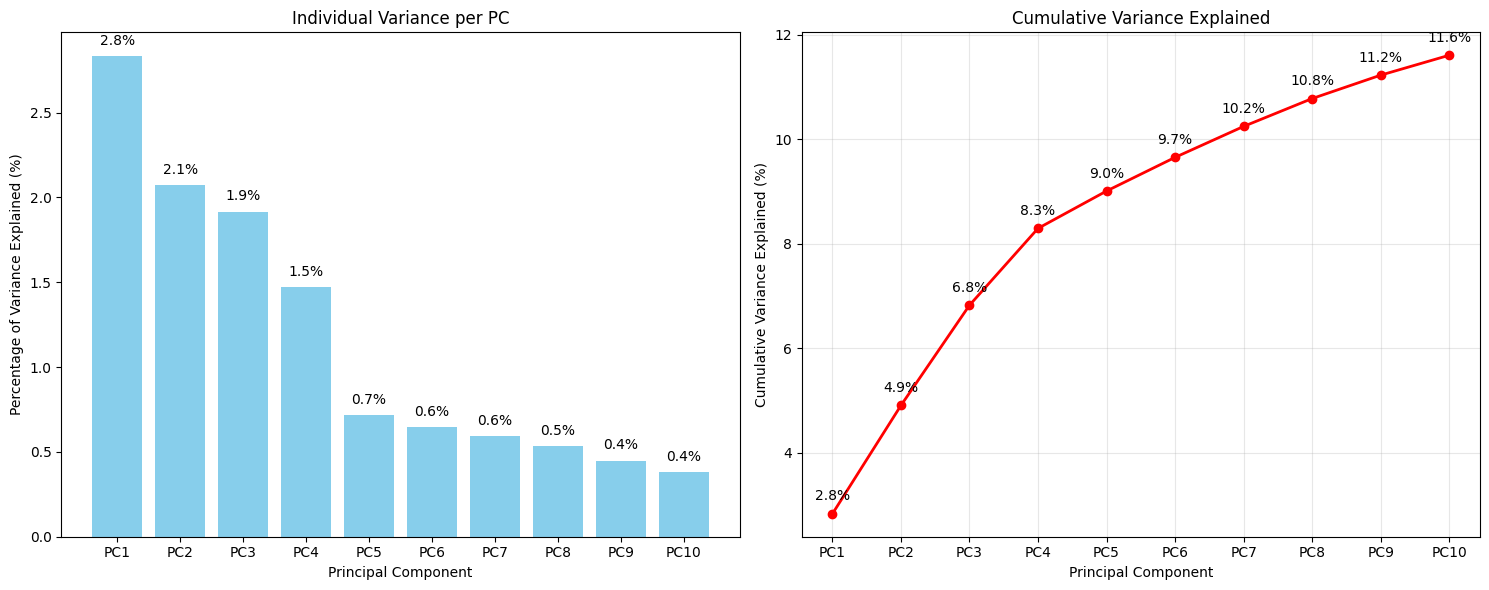

Total variance explained by first 10 PCs: 11.6%


In [18]:
# Enhanced version with cumulative variance
variance_ratio = adata.uns['pca']['variance_ratio'][:10] * 100
cumulative_variance = np.cumsum(variance_ratio)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Individual variance (your current plot)
bars = ax1.bar(pc_names, variance_ratio, color='skyblue')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Percentage of Variance Explained (%)')
ax1.set_title('Individual Variance per PC')

# Add percentage labels
for bar, v in zip(bars, variance_ratio):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.05, 
             f'{v:.1f}%', ha='center', va='bottom')

# Cumulative variance
ax2.plot(pc_names, cumulative_variance, 'o-', color='red', linewidth=2)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Cumulative Variance Explained')
ax2.grid(True, alpha=0.3)

# Add cumulative percentages
for i, v in enumerate(cumulative_variance):
    ax2.text(i, v + 0.2, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pca_variance_analysis.png"), dpi=300)
plt.show()

print(f"Total variance explained by first 10 PCs: {cumulative_variance[-1]:.1f}%")

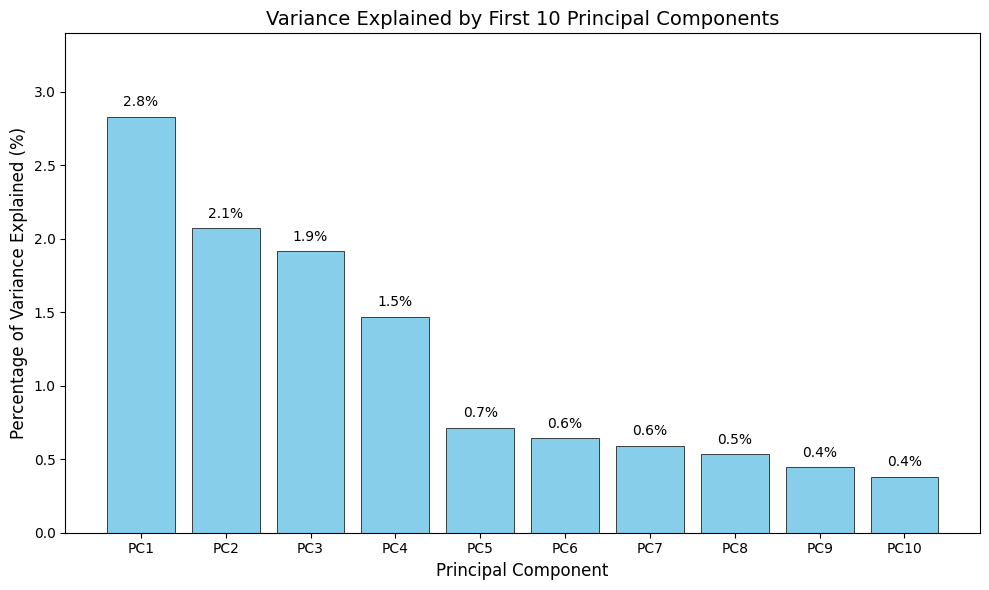

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Extract variance ratios and convert to percentages
variance_ratio = adata.uns['pca']['variance_ratio'][:10] * 100
pc_names = [f'PC{i+1}' for i in range(10)]

# Individual variance plot
plt.figure(figsize=(10, 6))
bars = plt.bar(pc_names, variance_ratio, color='skyblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Percentage of Variance Explained (%)', fontsize=12)
plt.title('Variance Explained by First 10 Principal Components', fontsize=14)
plt.ylim(0, max(variance_ratio) * 1.2)

# Add percentage labels on bars
for bar, v in zip(bars, variance_ratio):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, 
             f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pca_individual_variance.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, "pca_individual_variance.pdf"), bbox_inches='tight')  # PDF for LaTeX
plt.show()

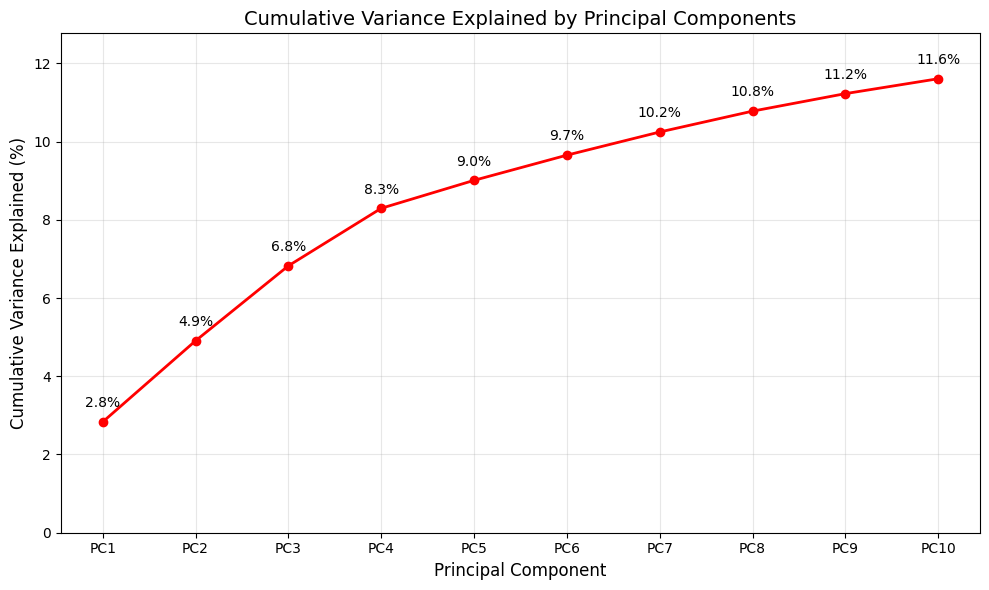

In [20]:
# Calculate cumulative variance
cumulative_variance = np.cumsum(variance_ratio)

# Cumulative variance plot
plt.figure(figsize=(10, 6))
plt.plot(pc_names, cumulative_variance, 'o-', color='red', linewidth=2, markersize=6)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Cumulative Variance Explained (%)', fontsize=12)
plt.title('Cumulative Variance Explained by Principal Components', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, max(cumulative_variance) * 1.1)

# Add cumulative percentages
for i, v in enumerate(cumulative_variance):
    plt.text(i, v + 0.3, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pca_cumulative_variance.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, "pca_cumulative_variance.pdf"), bbox_inches='tight')  # PDF for LaTeX
plt.show()

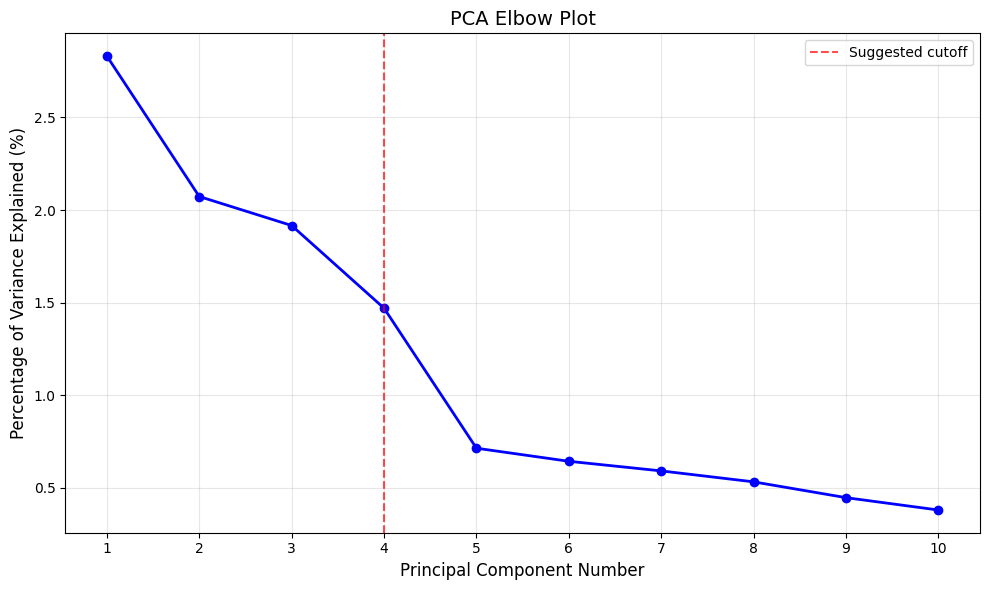

In [21]:
# Elbow plot - useful for determining optimal number of PCs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), variance_ratio, 'o-', color='blue', linewidth=2, markersize=6)
plt.xlabel('Principal Component Number', fontsize=12)
plt.ylabel('Percentage of Variance Explained (%)', fontsize=12)
plt.title('PCA Elbow Plot', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 11))

# Highlight the "elbow" (around PC4-5)
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Suggested cutoff')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pca_elbow_plot.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, "pca_elbow_plot.pdf"), bbox_inches='tight')  # PDF for LaTeX
plt.show()

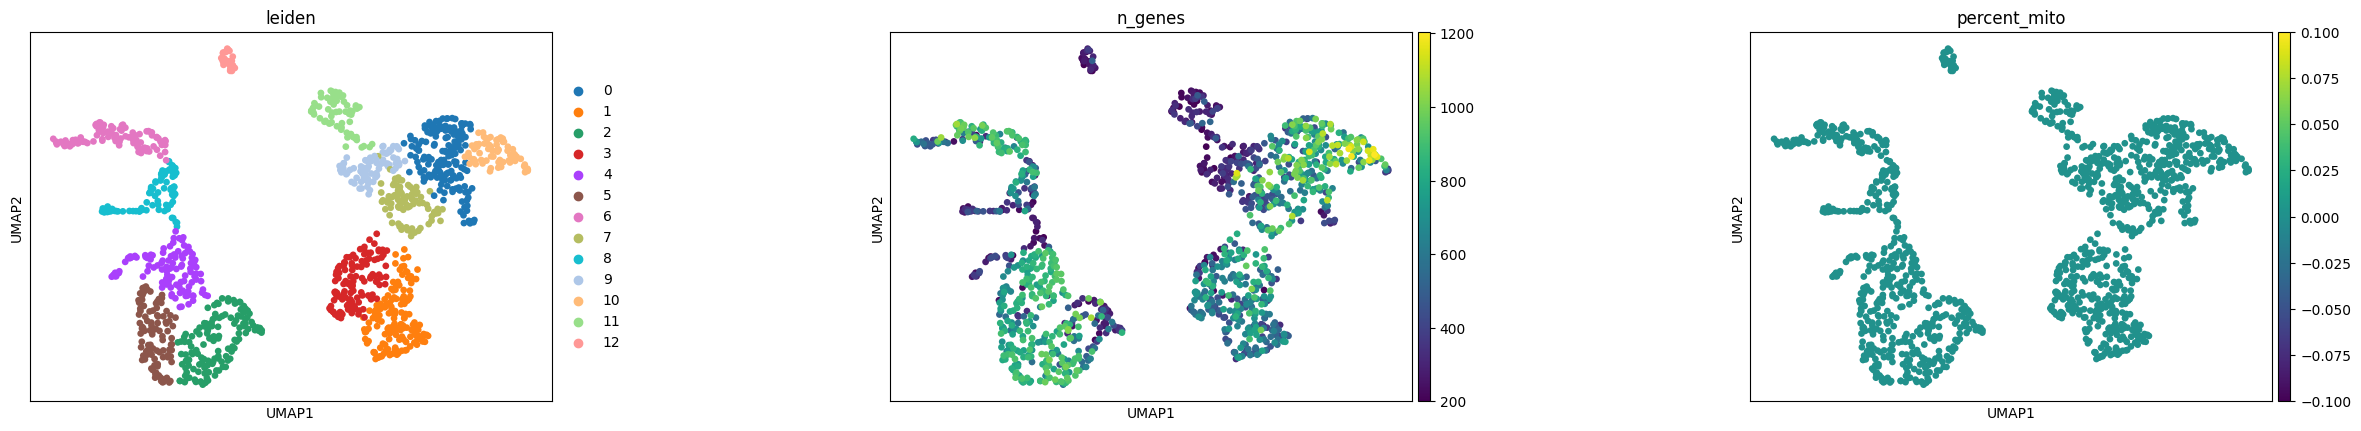

In [24]:
# Update your analysis with optimal number of PCs
n_pcs = 4  # Based on elbow plot analysis

# Recompute neighbors with optimal PCs
sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=10)

# Rerun clustering and UMAP
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)

# Plot results
sc.pl.umap(adata, color=['leiden', 'n_genes', 'percent_mito'], wspace=0.5)

<Figure size 800x600 with 0 Axes>

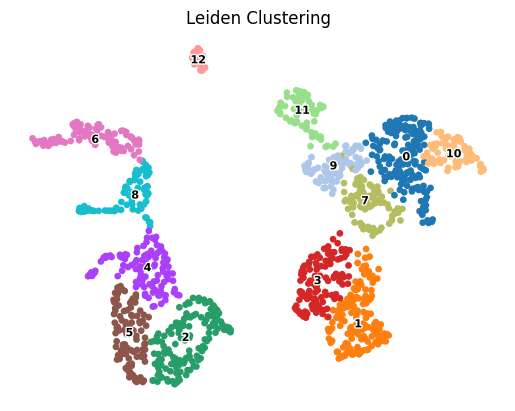

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

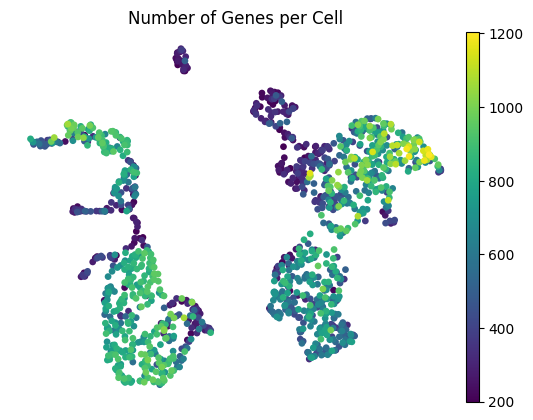

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

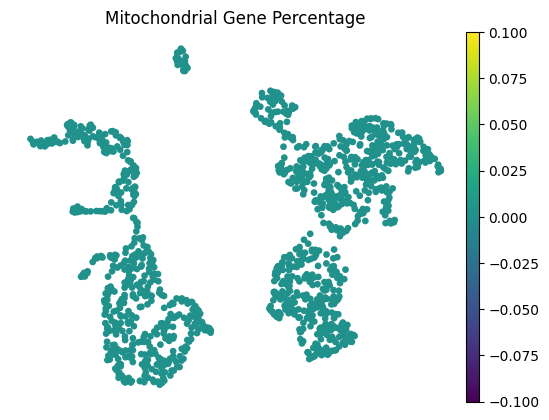

<Figure size 640x480 with 0 Axes>

Three separate UMAP plots saved successfully!
Files saved:
- umap_leiden_clusters.png/pdf
- umap_n_genes.png/pdf
- umap_percent_mito.png/pdf


In [25]:
import matplotlib.pyplot as plt
import scanpy as sc
import os

# Set output directory
output_dir = "/Users/nahian/Documents/RNA_Seq/Trim28_65/outs"

# Plot 1: Leiden Clustering
plt.figure(figsize=(8, 6))
sc.pl.umap(adata, color='leiden', legend_loc='on data', legend_fontsize=8, 
          legend_fontoutline=2, frameon=False, title='Leiden Clustering')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "umap_leiden_clusters.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, "umap_leiden_clusters.pdf"), bbox_inches='tight')
plt.show()

# Plot 2: Number of Genes
plt.figure(figsize=(8, 6))
sc.pl.umap(adata, color='n_genes', frameon=False, title='Number of Genes per Cell')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "umap_n_genes.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, "umap_n_genes.pdf"), bbox_inches='tight')
plt.show()

# Plot 3: Mitochondrial Percentage
plt.figure(figsize=(8, 6))
sc.pl.umap(adata, color='percent_mito', frameon=False, title='Mitochondrial Gene Percentage')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "umap_percent_mito.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, "umap_percent_mito.pdf"), bbox_inches='tight')
plt.show()

print("Three separate UMAP plots saved successfully!")
print("Files saved:")
print("- umap_leiden_clusters.png/pdf")
print("- umap_n_genes.png/pdf") 
print("- umap_percent_mito.png/pdf")